# ***1. Dependecies***

In [1]:
# ==============================================================================
# SECTION 1: SETUP AND DEPENDENCIES
# ==============================================================================

# Import all required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
# Import LSTM for the recurrent network
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

print("TensorFlow version:", tf.__version__)
print("Optuna version:", optuna.__version__)

C:\Users\paulo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TensorFlow version: 2.15.1
Optuna version: 4.5.0


# ***2. Multiclass model with Optuna***

In [2]:
# ==============================================================================
# SECTION 2: DATA LOADING AND 3D RESHAPING (FIXED SPLITTING AND COLUMN SELECTION) 
# ==============================================================================

print("\n" + "="*80)
print("STARTING SEQUENCE CLASSIFICATION (LSTM/RNN)")
print("="*80 + "\n")

# --- Reload processed data ---
output_file = 'Processed_Combined_Data_OMC_Final_Balanced_Dis.csv'
try:
    # NOTE: You must ensure this file exists from a previous data processing step.
    df = pd.read_csv(output_file)
    print(f"'{output_file}' loaded successfully. DataFrame shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: '{output_file}' not found. Please run the data generation script first.")
    exit()

# --- Data Separation and Cleanup ---
# Split data into Original (Real) and Synthetic based on part_id (assuming IDs < 3000 are Original)
df_original = df[df['part_id'] < 3000].copy() 
df_synthetic_full = df[df['part_id'] >= 3000].copy() 

# Define columns
target_columns = [col for col in df.columns if col.startswith('health_rate_') and not col.startswith('health_rate_comparison_')]

#  FIXED LINE: Use the '+' operator to create a list of columns to drop.
# This prevents the list.append() method from returning None, which caused the KeyError.
columns_to_drop = target_columns + ['part_id']
feature_columns = df.columns.drop(columns_to_drop).tolist() # Convert Index to list for clarity

N_VISITS = 4 # The required sequence length


STARTING SEQUENCE CLASSIFICATION (LSTM/RNN)

'Processed_Combined_Data_OMC_Final_Balanced_Dis.csv' loaded successfully. DataFrame shape: (16021, 245)


In [3]:


# ----------------------------------------------------------------------------------
#  STEP 1: Identify all COMPLETE synthetic patients and their END-OF-TRAJECTORY label
# ----------------------------------------------------------------------------------

# Group by patient and filter for only complete trajectories (4 visits)
visit_counts = df_synthetic_full.groupby('part_id').size()
complete_ids = visit_counts[visit_counts == N_VISITS].index

# Filter the full synthetic data to only include complete patients
df_synthetic_complete = df_synthetic_full[df_synthetic_full['part_id'].isin(complete_ids)].copy()

# Get the final health class for each patient (the label for stratification)
last_visit_indices = df_synthetic_complete.groupby('part_id').tail(1).index
df_patient_labels = df_synthetic_complete.loc[last_visit_indices, ['part_id'] + target_columns].copy()

# Determine the single class label based on the final visit's one-hot encoding
df_patient_labels['health_rate_class'] = df_patient_labels[target_columns].idxmax(axis=1)

# X is the list of patient IDs, Y is the end-of-trajectory label for stratification
X_patient_ids = df_patient_labels['part_id'].values.reshape(-1, 1) # Reshape for SSS input
Y_patient_labels = df_patient_labels['health_rate_class'].values

print(f"Total complete synthetic patients available for split: {len(X_patient_ids)}")

# ----------------------------------------------------------------------------------
#  STEP 2: Use StratifiedShuffleSplit on the PATIENT IDs
# ----------------------------------------------------------------------------------
TRAIN_FRACTION = 0.7
TEST_FRACTION = 0.3 

# Apply StratifiedShuffleSplit to the list of unique patient IDs (X) and their labels (Y)
sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_FRACTION, random_state=42)

for train_patient_index, test_patient_index in sss.split(X_patient_ids, Y_patient_labels):
    # Get the actual patient IDs for train and test sets
    train_patient_ids = X_patient_ids[train_patient_index].flatten()
    test_patient_ids = X_patient_ids[test_patient_index].flatten()

# Filter the FLAT synthetic data using the sampled patient IDs
df_train_flat = df_synthetic_complete[df_synthetic_complete['part_id'].isin(train_patient_ids)].copy()
df_test_synthetic_flat = df_synthetic_complete[df_synthetic_complete['part_id'].isin(test_patient_ids)].copy()

# ----------------------------------------------------------------------------------
#  STEP 3: Define Test Sets and Reshape
# ----------------------------------------------------------------------------------

# Test Set 1: All Real Data (Filtered to 4 visits by the reshape function)
df_test_real_all_flat = df_original.copy()

# Test Set 3: Combined Test Set
df_test_combined_flat = pd.concat([df_test_real_all_flat, df_test_synthetic_flat], ignore_index=True)

Total complete synthetic patients available for split: 3976


In [22]:
# ==============================================================================
#  SEQUENCE RESHAPING FUNCTION
# ==============================================================================

def reshape_to_sequence(df_flat, feature_cols, target_cols, n_visits=4):
    """
    Groups the flat DataFrame by 'part_id', filters for complete trajectories, 
    and reshapes it into the 3D tensor format (Samples, Timesteps, Features). 
    The label is taken from the FINAL visit.
    """
    
    # Group by patient and count the number of visits
    visit_counts = df_flat.groupby('part_id').size()
    
    # Get the IDs of patients who have exactly n_visits
    complete_trajectory_ids = visit_counts[visit_counts == n_visits].index
    
    # Filter the DataFrame to include only complete trajectories
    df_filtered = df_flat[df_flat['part_id'].isin(complete_trajectory_ids)]
    
    # Group Features (X)
    grouped_features = df_filtered.groupby('part_id')[feature_cols].apply(lambda x: x.values)
    X_list = grouped_features.tolist()
    
    # Group Targets (Y) - Use the one-hot target from the FINAL visit
    grouped_targets = df_filtered.groupby('part_id')[target_cols].apply(lambda x: x.values[-1])
    Y_last_visit_targets = grouped_targets.tolist()
    
    # Stacking to create the 3D tensor
    X_seq = np.stack(X_list)
    Y_seq_one_hot = np.stack(Y_last_visit_targets) 
    Y_seq = np.argmax(Y_seq_one_hot, axis=1) # Convert one-hot to index label

    part_ids = complete_trajectory_ids.values
    
    print(f"Processed {len(part_ids)} patient trajectories out of {visit_counts.size} total groups in source.")
    
    return X_seq, Y_seq, part_ids

# --- Apply Reshaping to ALL Sets ---
X_train_seq, Y_train_seq, train_part_ids = reshape_to_sequence(df_train_flat, feature_columns, target_columns, N_VISITS)
X_test_real_seq, Y_test_real_seq, test_real_part_ids = reshape_to_sequence(df_test_real_all_flat, feature_columns, target_columns, N_VISITS)
X_test_synth_seq, Y_test_synth_seq, test_synth_part_ids = reshape_to_sequence(df_test_synthetic_flat, feature_columns, target_columns, N_VISITS)
X_test_combined_seq, Y_test_combined_seq, test_combined_part_ids = reshape_to_sequence(df_test_combined_flat, feature_columns, target_columns, N_VISITS)

# Label Encoding - Fit on the final, sequential targets
le = LabelEncoder()
Y_train_seq_encoded = le.fit_transform(Y_train_seq) # Fit on the indices from the training set

# Recalculate Test Set Labels using the fitted encoder
Y_test_real_seq_encoded = le.transform(Y_test_real_seq)
Y_test_synth_seq_encoded = le.transform(Y_test_synth_seq)
Y_test_combined_seq_encoded = le.transform(Y_test_combined_seq)

# Reassign for consistent variable names used in training
Y_train_seq = Y_train_seq_encoded
Y_test_real_seq = Y_test_real_seq_encoded
Y_test_synth_seq = Y_test_synth_seq_encoded
Y_test_combined_seq = Y_test_combined_seq_encoded

# Get parameters for the RNN model
N_TIMESTEPS = X_train_seq.shape[1] # Should be 4
N_FEATURES = X_train_seq.shape[2] 
num_classes = len(le.classes_) 

print("\n" + "-"*40)
print("FINAL DATASET SHAPES (SEQUENCE RNN FORMAT)")
print("-" * 40)
print(f"Training data shape (Patients, Visits, Features): {X_train_seq.shape}")
print(f"Test Set 1 (All Real) shape: {X_test_real_seq.shape}")
print(f"Test Set 2 (Synthetic 30% Never Seen) shape: {X_test_synth_seq.shape}")
print(f"Test Set 3 (Combined Test Data: T1 + T2) shape: {X_test_combined_seq.shape}")
print("-" * 40 + "\n")


Processed 2783 patient trajectories out of 2783 total groups in source.
Processed 27 patient trajectories out of 30 total groups in source.
Processed 1193 patient trajectories out of 1193 total groups in source.
Processed 1220 patient trajectories out of 1223 total groups in source.

----------------------------------------
FINAL DATASET SHAPES (SEQUENCE RNN FORMAT)
----------------------------------------
Training data shape (Patients, Visits, Features): (2783, 4, 239)
Test Set 1 (All Real) shape: (27, 4, 239)
Test Set 2 (Synthetic 30% Never Seen) shape: (1193, 4, 239)
Test Set 3 (Combined Test Data: T1 + T2) shape: (1220, 4, 239)
----------------------------------------



In [5]:

# ==============================================================================
# SECTION 3: OPTUNA OBJECTIVE FUNCTION (ADAPTED FOR LSTM)
# ==============================================================================

def objective_lstm(trial):
    """
    Defines the LSTM model and hyperparameters to optimize.
    """
    #  LSTM/RNN Hyperparameters
    lstm_units = trial.suggest_int('lstm_units', 32, 256, log=True) # Units in the LSTM layer
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True) 
    patience = trial.suggest_int('patience', 10, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop']) 
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.4)
    
    model = Sequential()
    
    #  Use LSTM layer which accepts the 3D input (Timesteps, Features)
    model.add(LSTM(lstm_units, 
                   input_shape=(N_TIMESTEPS, N_FEATURES),
                   dropout=dropout_rate,
                   recurrent_dropout=dropout_rate)) 
    
    # Final dense layers for classification on the last time step's output
    model.add(Dense(lstm_units // 2, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    if optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else: 
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    history = model.fit(
        X_train_seq,
        Y_train_seq,
        epochs=1500,
        validation_split=0.2, 
        callbacks=[early_stopping],
        verbose=0
    )
    
    best_val_accuracy = max(history.history['val_accuracy'])
    return best_val_accuracy

In [6]:

    
# ==============================================================================
# SECTION 4: RUN OPTUNA STUDY AND RETRAIN MODEL
# ==============================================================================
#'''
print("\n" + "="*80)
print("STARTING OPTUNA HYPERPARAMETER OPTIMIZATION (LSTM)")
print("="*80 + "\n")

study = optuna.create_study(direction='maximize')
# Reduced n_trials for quicker execution; adjust as needed for better results
study.optimize(objective_lstm, n_trials=30) 

print("\n" + "="*80)
print("BEST HYPERPARAMETERS FOUND BY OPTUNA (LSTM)")
print("="*80 + "\n")
best_params = study.best_params
print(best_params)
#'''

[I 2025-11-13 17:09:33,553] A new study created in memory with name: no-name-b241139f-d2ea-4fab-9f2d-3d344623433e



STARTING OPTUNA HYPERPARAMETER OPTIMIZATION (LSTM)






[I 2025-11-13 17:10:47,194] Trial 0 finished with value: 0.9156193733215332 and parameters: {'lstm_units': 72, 'learning_rate': 0.0002969493243685437, 'patience': 35, 'optimizer': 'RMSprop', 'dropout_rate': 0.2482287376399469}. Best is trial 0 with value: 0.9156193733215332.
[I 2025-11-13 17:11:11,526] Trial 1 finished with value: 0.9174147248268127 and parameters: {'lstm_units': 120, 'learning_rate': 0.004328521959395821, 'patience': 17, 'optimizer': 'Adam', 'dropout_rate': 0.2903802358579659}. Best is trial 1 with value: 0.9174147248268127.
[I 2025-11-13 17:11:51,889] Trial 2 finished with value: 0.9174147248268127 and parameters: {'lstm_units': 72, 'learning_rate': 0.002084503322434714, 'patience': 48, 'optimizer': 'RMSprop', 'dropout_rate': 0.18049017534508915}. Best is trial 1 with value: 0.9174147248268127.
[I 2025-11-13 17:12:18,324] Trial 3 finished with value: 0.9138240814208984 and parameters: {'lstm_units': 46, 'learning_rate': 0.0021698342904352603, 'patience': 26, 'optimiz


BEST HYPERPARAMETERS FOUND BY OPTUNA (LSTM)

{'lstm_units': 40, 'learning_rate': 0.005608437570562409, 'patience': 24, 'optimizer': 'Adam', 'dropout_rate': 0.06504229836504787}


In [23]:
best_params = {'lstm_units': 40, 'learning_rate': 0.005608437570562409, 'patience': 24, 'optimizer': 'Adam', 'dropout_rate': 0.06504229836504787}

In [24]:


# --- Retrain Final LSTM Model ---
best_model = Sequential()
best_model.add(LSTM(best_params['lstm_units'], 
                    input_shape=(N_TIMESTEPS, N_FEATURES),
                    dropout=best_params['dropout_rate'],
                    recurrent_dropout=best_params['dropout_rate']))

best_model.add(Dense(best_params['lstm_units'] // 2, activation='relu'))
best_model.add(Dense(num_classes, activation='softmax'))


if best_params['optimizer'] == 'Adam':
    best_optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
else: 
    best_optimizer = tf.keras.optimizers.RMSprop(learning_rate=best_params['learning_rate'])

best_model.compile(loss='sparse_categorical_crossentropy', optimizer=best_optimizer, metrics=['accuracy'])
best_early_stopping = EarlyStopping(monitor='val_loss', patience=best_params['patience'], restore_best_weights=True)

print("\nTraining final LSTM model with best hyperparameters...")
best_model.fit(
    X_train_seq,
    Y_train_seq,
    epochs=2000, 
    validation_split=0.2, 
    callbacks=[best_early_stopping],
    verbose=1
)


Training final LSTM model with best hyperparameters...
Epoch 1/2000
70/70 [==============================] - 5s 16ms/step - loss: 0.8138 - accuracy: 0.6752 - val_loss: 0.4795 - val_accuracy: 0.8294
Epoch 2/2000
70/70 [==============================] - 1s 9ms/step - loss: 0.4033 - accuracy: 0.8437 - val_loss: 0.4724 - val_accuracy: 0.8061
Epoch 3/2000
70/70 [==============================] - 1s 9ms/step - loss: 0.3318 - accuracy: 0.8625 - val_loss: 0.3643 - val_accuracy: 0.8636
Epoch 4/2000
70/70 [==============================] - 1s 9ms/step - loss: 0.2648 - accuracy: 0.8962 - val_loss: 0.3387 - val_accuracy: 0.8564
Epoch 5/2000
70/70 [==============================] - 1s 8ms/step - loss: 0.2393 - accuracy: 0.9039 - val_loss: 0.3096 - val_accuracy: 0.9031
Epoch 6/2000
70/70 [==============================] - 1s 10ms/step - loss: 0.2002 - accuracy: 0.9182 - val_loss: 0.3004 - val_accuracy: 0.8977
Epoch 7/2000
70/70 [==============================] - 1s 9ms/step - loss: 0.1673 - accurac

In [25]:


# ==============================================================================
# SECTION 5: TRIPLE EVALUATION AND PLOTTING (ORIGINAL LABELS SHOWN) 
# ==============================================================================

# Helper function to calculate and print metrics and return confusion matrix
def calculate_and_print_metrics_seq(X_data_seq, Y_true_seq, set_name):
    # Predict on the 3D sequence data
    Y_pred_seq = np.argmax(best_model.predict(X_data_seq), axis=1)
    
    acc = accuracy_score(Y_true_seq, Y_pred_seq)
    precision_macro = precision_score(Y_true_seq, Y_pred_seq, average='macro', zero_division=0)
    recall_macro = recall_score(Y_true_seq, Y_pred_seq, average='macro', zero_division=0)
    f1_macro = f1_score(Y_true_seq, Y_pred_seq, average='macro', zero_division=0)
    precision_weighted = precision_score(Y_true_seq, Y_pred_seq, average='weighted', zero_division=0)
    recall_weighted = recall_score(Y_true_seq, Y_pred_seq, average='weighted', zero_division=0)
    f1_weighted = f1_score(Y_true_seq, Y_pred_seq, average='weighted', zero_division=0)

    print(f"\n--- {set_name} Metrics (Patients: {len(Y_true_seq)}) ---")
    print(f'Accuracy: {np.round(acc * 100, 2)}%')
    print(f'Precision (Macro): {np.round(precision_macro * 100, 2)}%')
    print(f'Recall (Macro): {np.round(recall_macro * 100, 2)}%')
    print(f'F1-score (Macro): {np.round(f1_macro * 100, 2)}%')
    print(f'Precision (Weighted): {np.round(precision_weighted * 100, 2)}%')
    print(f'Recall (Weighted): {np.round(recall_weighted * 100, 2)}%')
    print(f'F1-score (Weighted): {np.round(f1_weighted * 100, 2)}%')
    
    # Pass the total number of expected classes labels to ensure the CM is shaped correctly
    conf_mat = confusion_matrix(Y_true_seq, Y_pred_seq, labels=le.transform(le.classes_))
    print(f"\nConfusion Matrix ({set_name} - Raw Counts):")
    print(conf_mat)
    
    return conf_mat




FINAL PERFORMANCE METRICS COMPARISON (THREE SEQUENCE TEST SETS)
1/1 [==============================] - 0s 36ms/step

--- 1. All Real Data Metrics (Patients: 27) ---
Accuracy: 66.67%
Precision (Macro): 79.72%
Recall (Macro): 85.43%
F1-score (Macro): 74.1%
Precision (Weighted): 92.08%
Recall (Weighted): 66.67%
F1-score (Weighted): 74.67%

Confusion Matrix (1. All Real Data - Raw Counts):
[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 7 0 3]
 [0 0 1 8 5]
 [0 0 0 0 1]]
38/38 [==============================] - 0s 4ms/step

--- 2. Synthetic Data (Never Seen) Metrics (Patients: 1193) ---
Accuracy: 86.17%
Precision (Macro): 87.28%
Recall (Macro): 84.18%
F1-score (Macro): 85.54%
Precision (Weighted): 86.3%
Recall (Weighted): 86.17%
F1-score (Weighted): 86.17%

Confusion Matrix (2. Synthetic Data (Never Seen) - Raw Counts):
[[178   0   0   0  22]
 [  0  52   0   0  17]
 [  1   1 185   4  17]
 [  0   0   2 128  29]
 [ 15   3  24  30 485]]
39/39 [==============================] - 0s 3ms/step

--- 3. Combined Te

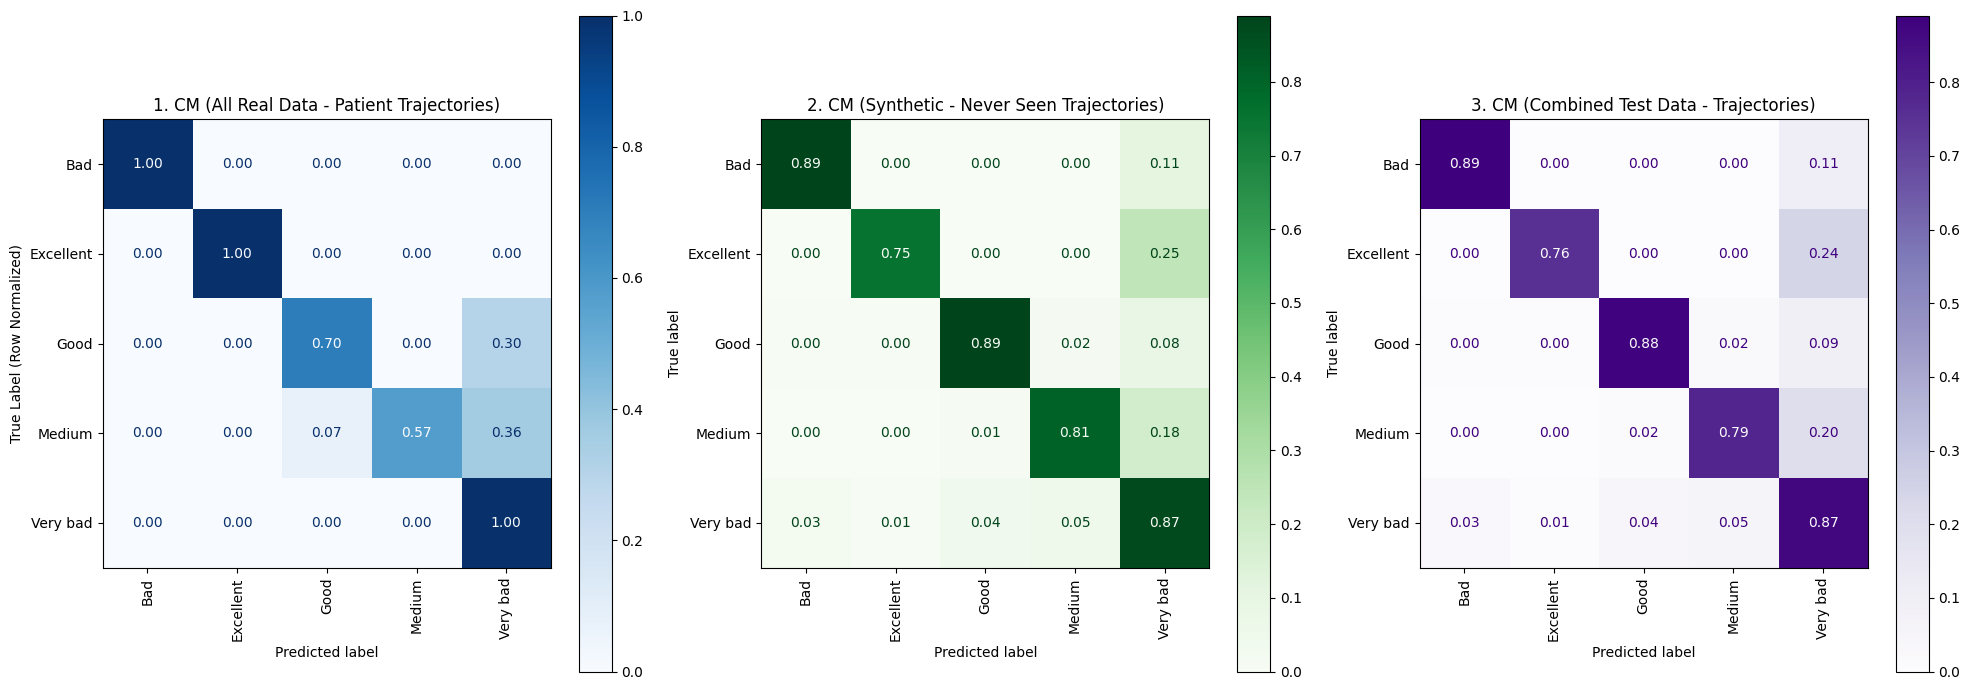

In [30]:
print("\n" + "="*80)
print("FINAL PERFORMANCE METRICS COMPARISON (THREE SEQUENCE TEST SETS)")
print("="*80)

# --- Test 1: All Real Data (Patients) ---
conf_mat_real_all = calculate_and_print_metrics_seq(X_test_real_seq, Y_test_real_seq, "1. All Real Data")

# --- Test 2: Synthetic Data Sample (Patients) ---
conf_mat_synth = calculate_and_print_metrics_seq(X_test_synth_seq, Y_test_synth_seq, "2. Synthetic Data (Never Seen)")

# --- Test 3: Combined Data Sample (Patients) ---
conf_mat_combined = calculate_and_print_metrics_seq(X_test_combined_seq, Y_test_combined_seq, "3. Combined Test Data")

# --- Triple Confusion Matrix Plotting ---
# Get the original string labels from the LabelEncoder for the plot axes

# 1. Instantiate the LabelEncoder
TRUE_CLASS_LABELS = [
    'health_rate_Bad', 
    'health_rate_Excellent', 
    'health_rate_Good', 
    'health_rate_Medium', 
    'health_rate_Very bad'
]
le = LabelEncoder()

le.fit(TRUE_CLASS_LABELS) 

num_classes = len(le.classes_)

clabels = le.classes_ 

clabels = [c.replace('health_rate_', '') for c in le.classes_]

# Calculate Normalized Confusion Matrices (Row normalization: True Positives Rate)
def normalize_cm(conf_mat):
    # Normalize by the sum of each row (True Label total)
    row_sums = conf_mat.sum(axis=1)[:, np.newaxis]
    return np.where(row_sums > 0, conf_mat.astype('float') / row_sums, 0)


conf_mat_real_all_norm = normalize_cm(conf_mat_real_all)
conf_mat_synth_norm = normalize_cm(conf_mat_synth)
conf_mat_combined_norm = normalize_cm(conf_mat_combined)

# Define the figure size for a good 1x3 layout.
plt.figure(figsize=(20, 7)) 

# Plot 1: All Real Data -> Left
plt.subplot(1, 3, 1)
# Using clabels for display_labels shows the original string names
cm_display_1 = ConfusionMatrixDisplay(confusion_matrix=conf_mat_real_all_norm, display_labels=clabels)
cm_display_1.plot(cmap=plt.cm.Blues, ax=plt.gca(), xticks_rotation='vertical', values_format='.2f')
plt.title('1. CM (All Real Data - Patient Trajectories)')
plt.ylabel('True Label (Row Normalized)') 

# Plot 2: Synthetic Data Sample -> Center
plt.subplot(1, 3, 2)
# Using clabels for display_labels shows the original string names
cm_display_2 = ConfusionMatrixDisplay(confusion_matrix=conf_mat_synth_norm, display_labels=clabels)
cm_display_2.plot(cmap=plt.cm.Greens, ax=plt.gca(), xticks_rotation='vertical', values_format='.2f')
plt.title('2. CM (Synthetic - Never Seen Trajectories)')

# Plot 3: Combined Data Sample -> Right
plt.subplot(1, 3, 3)
# Using clabels for display_labels shows the original string names
cm_display_3 = ConfusionMatrixDisplay(confusion_matrix=conf_mat_combined_norm, display_labels=clabels)
cm_display_3.plot(cmap=plt.cm.Purples, ax=plt.gca(), xticks_rotation='vertical', values_format='.2f')
plt.title('3. CM (Combined Test Data - Trajectories)')

# Adjust layout for presentation
plt.tight_layout()
plt.show()